In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pandas as pd
from pathlib import Path
from os.path import join
from glob import glob

sns.set()
sns.set_palette('colorblind');

In [2]:
def read_csvx(path, *args, **kwargs):
    try:
        return pd.read_csv(str(path) +'.gz', *args, **kwargs)
    except Exception as e:
        print(e)
        return pd.read_csv(path, *args, **kwargs)

/data/logs/ab-testing-2018-08-01-1128/a_0b_3/run_1/rep00/fitnesslog.txt


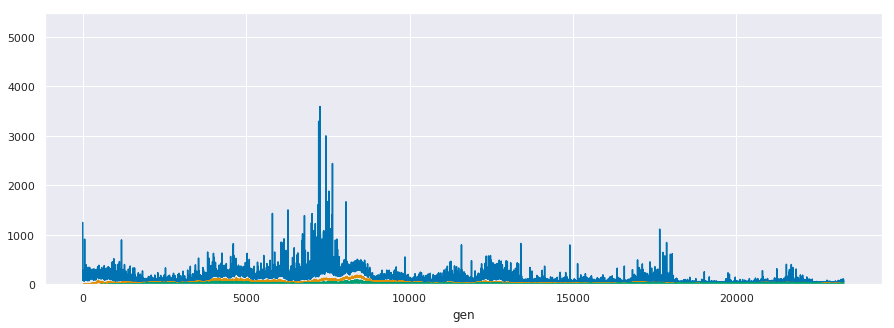

gen: 19999


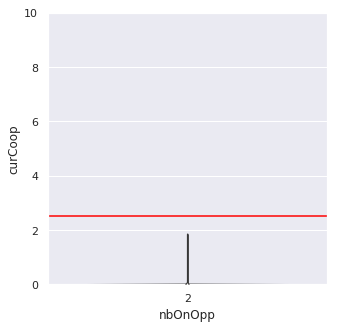

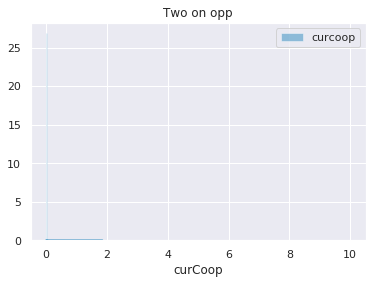

0.0007641593525976478


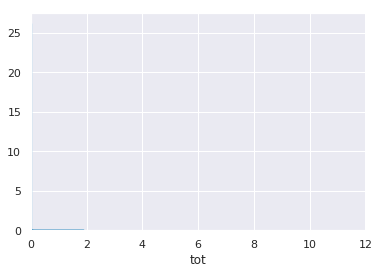

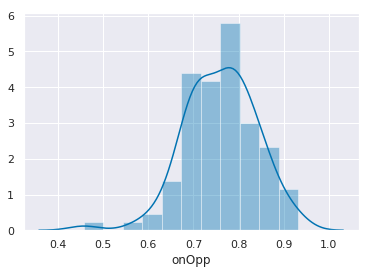

/data/logs/ab-testing-2018-08-01-1128/a_0b_3/run_2/rep00/fitnesslog.txt


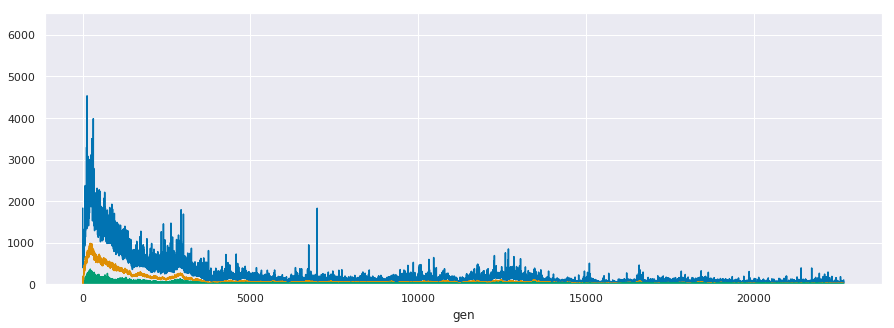

gen: 19999


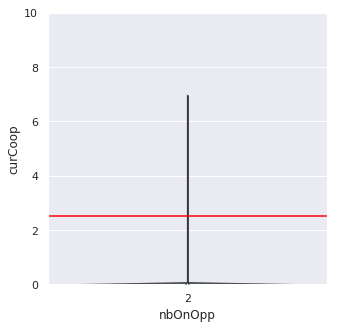

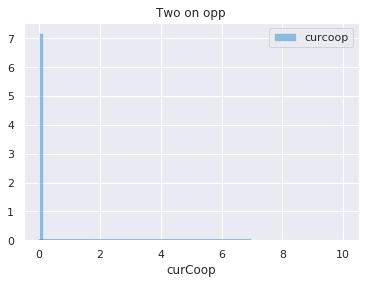

0.0010094371179515903


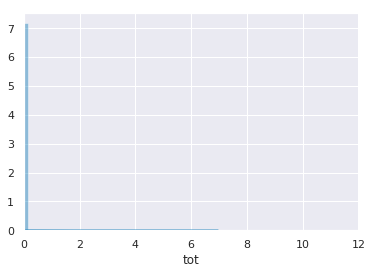

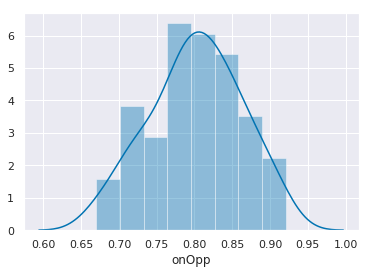

/data/logs/ab-testing-2018-08-01-1128/a_0b_3/run_3/rep00/fitnesslog.txt


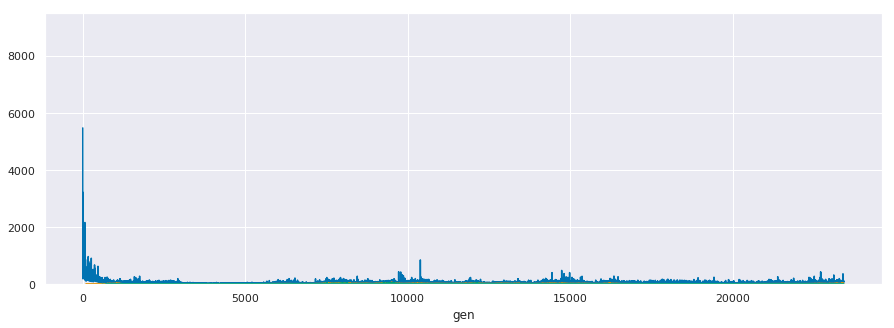

gen: 19999


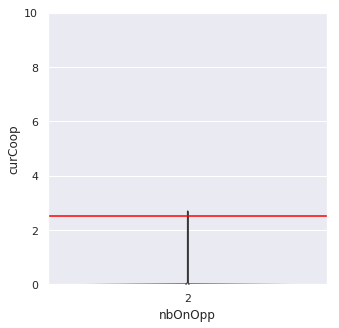

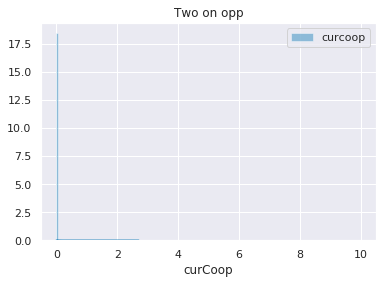

0.00046631911883221564


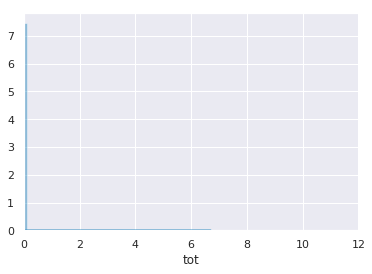

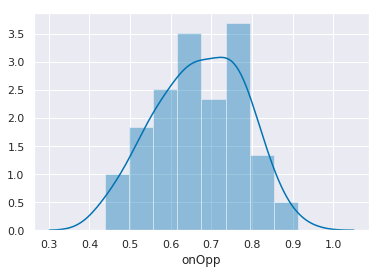

/data/logs/ab-testing-2018-08-01-1128/a_0b_3/run_4/rep00/fitnesslog.txt


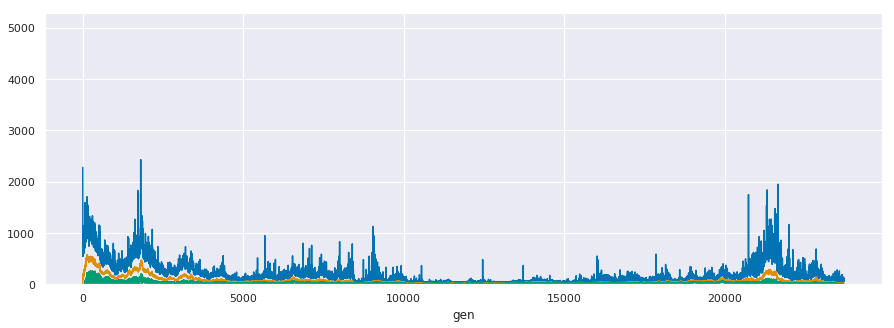

gen: 19999


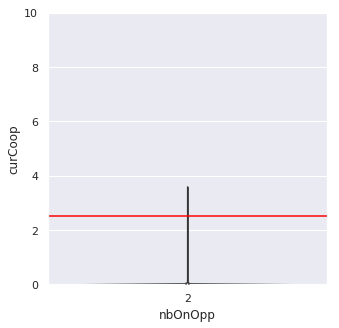

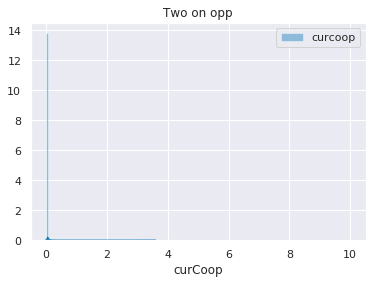

0.006668637128958997


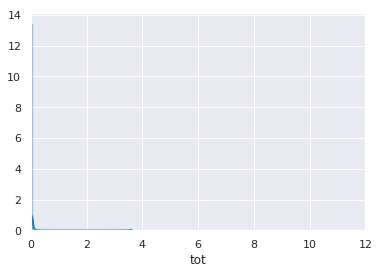

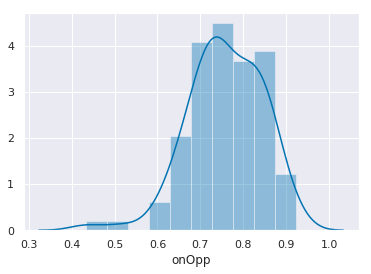

/data/logs/ab-testing-2018-08-01-1128/a_0b_3/run_5/rep00/fitnesslog.txt


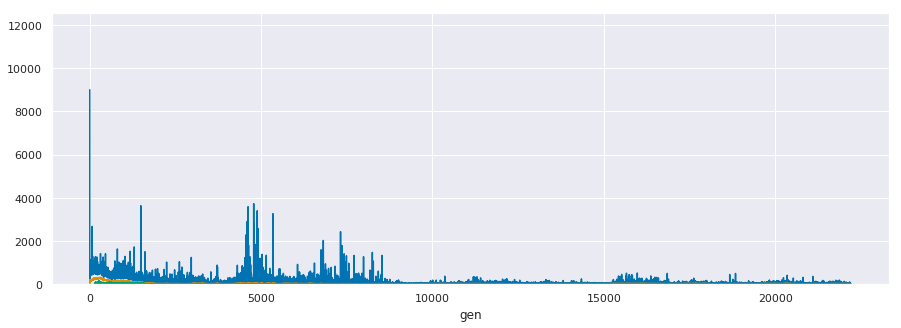

gen: 19999


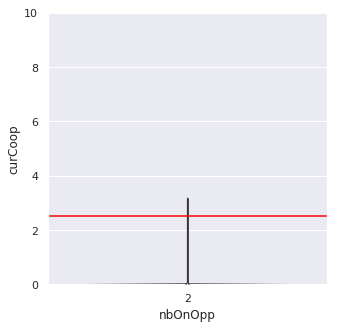

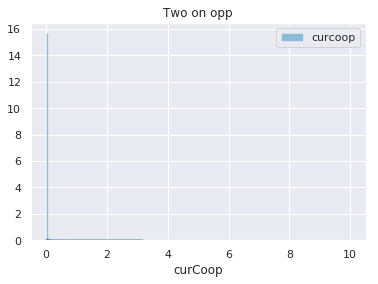

0.0025789577557173205


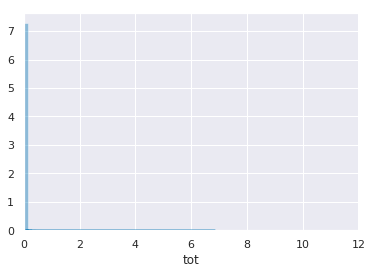

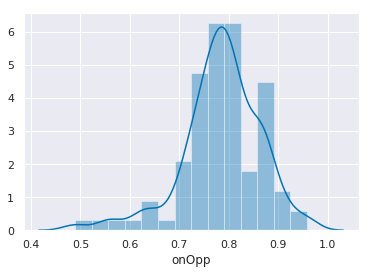

/data/logs/ab-testing-2018-08-01-1128/a_5b_3/run_1/rep00/fitnesslog.txt


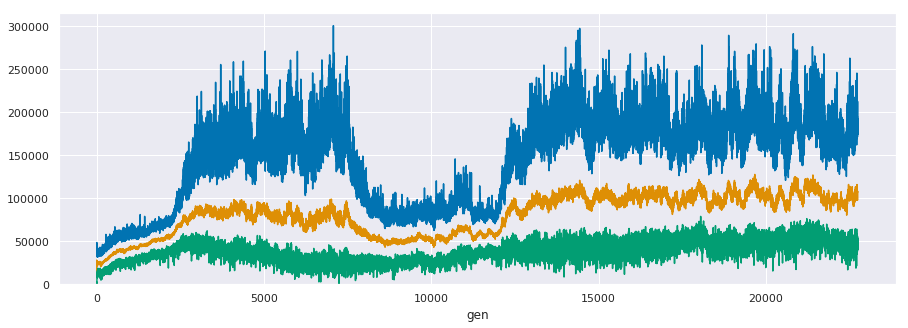

gen: 19999


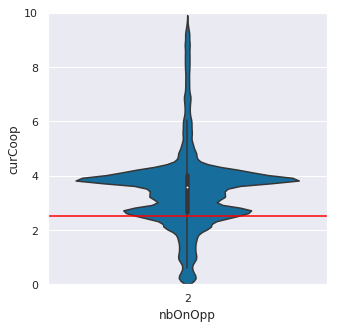

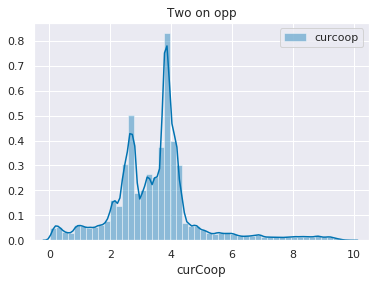

3.4707855251391893


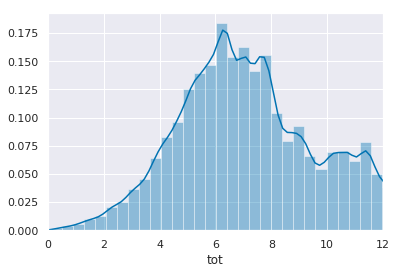

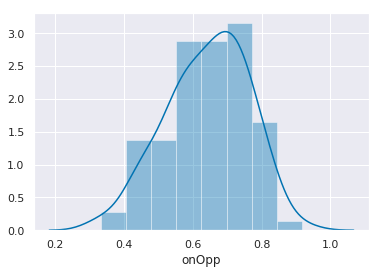

/data/logs/ab-testing-2018-08-01-1128/a_5b_3/run_2/rep00/fitnesslog.txt


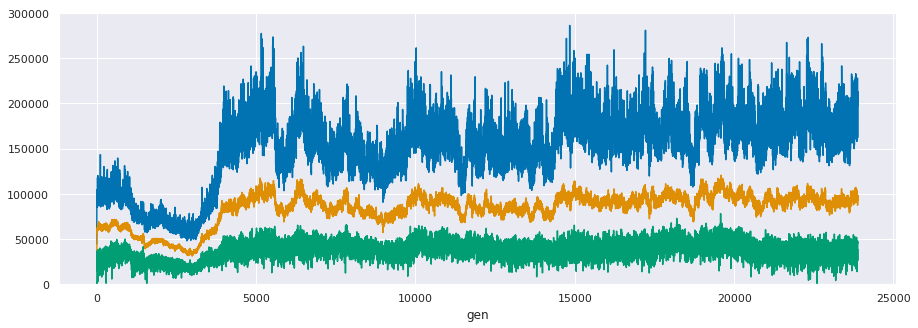

gen: 19999


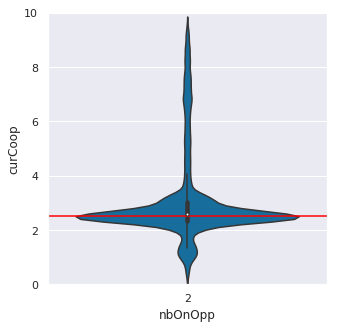

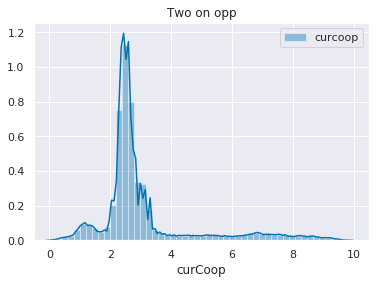

3.0707185061300315


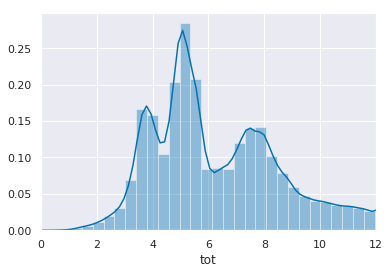

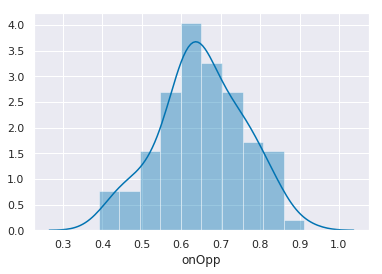

/data/logs/ab-testing-2018-08-01-1128/a_5b_3/run_3/rep00/fitnesslog.txt


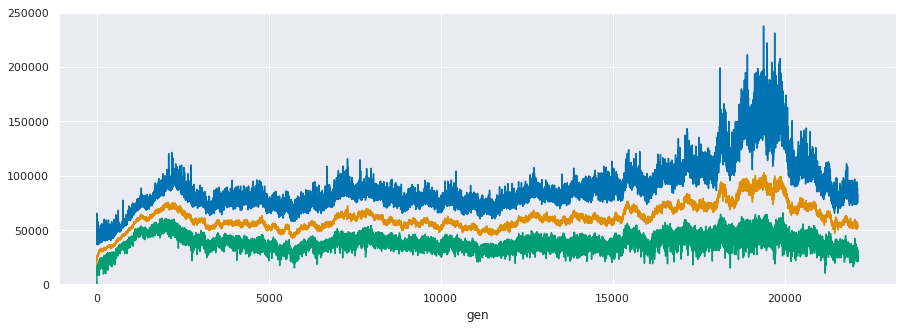

gen: 19999


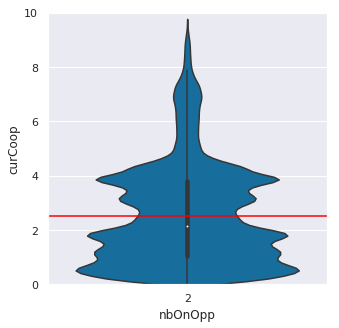

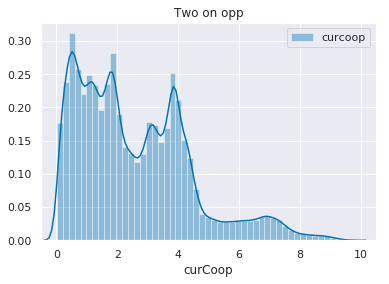

2.5600708689312857


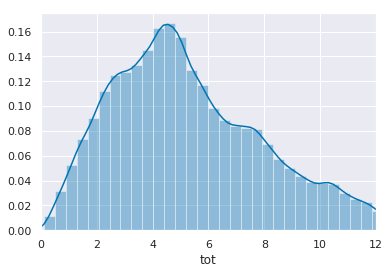

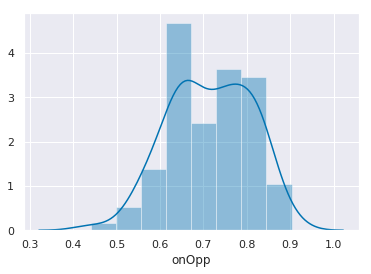

/data/logs/ab-testing-2018-08-01-1128/a_5b_3/run_4/rep00/fitnesslog.txt


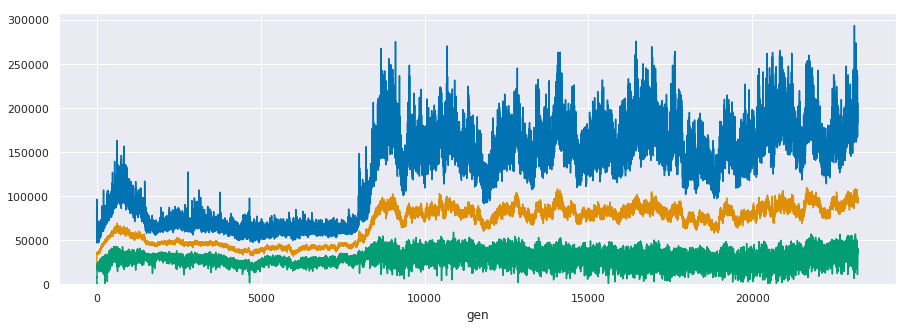

gen: 19999


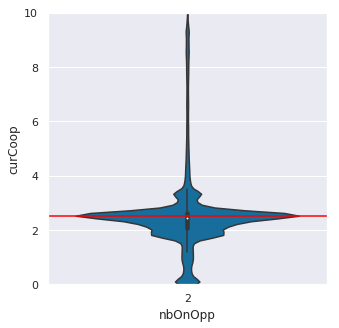

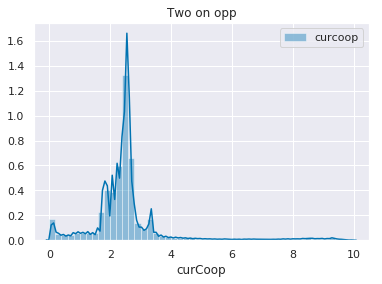

2.55115611954324


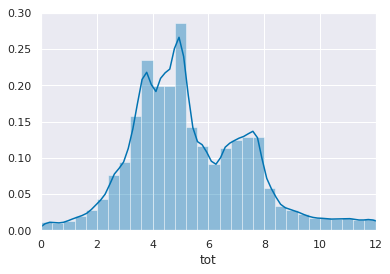

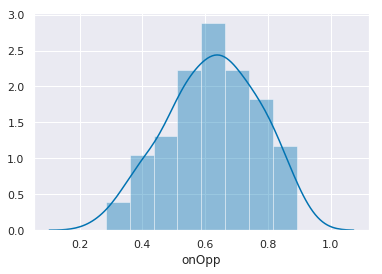

/data/logs/ab-testing-2018-08-01-1128/a_5b_3/run_5/rep00/fitnesslog.txt


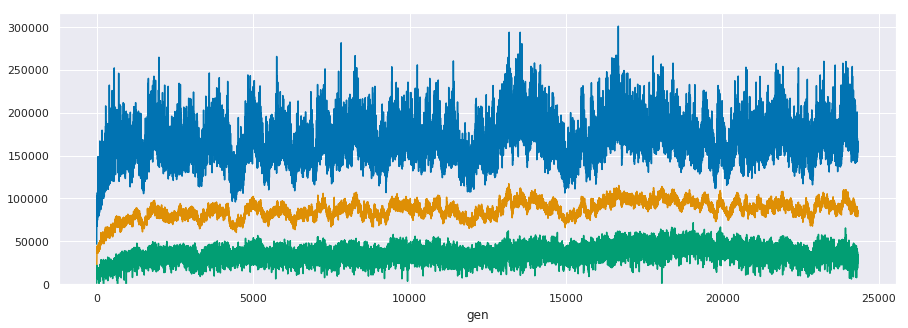

gen: 19999


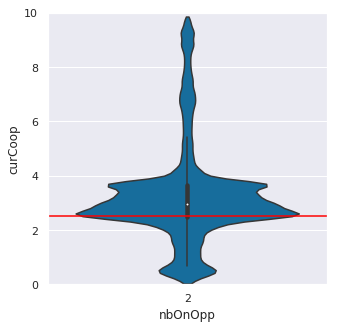

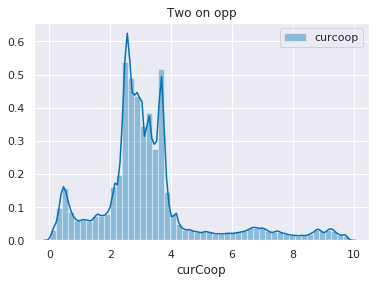

3.2480031051746265


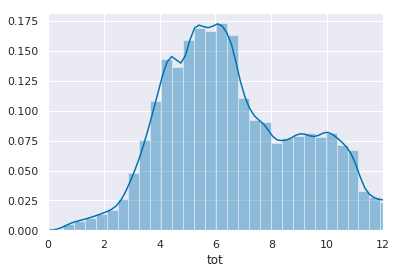

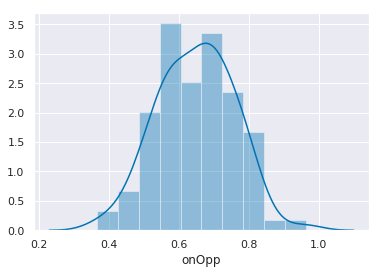

/data/logs/ab-testing-2018-08-01-1128/a_5b_8/run_1/rep00/fitnesslog.txt


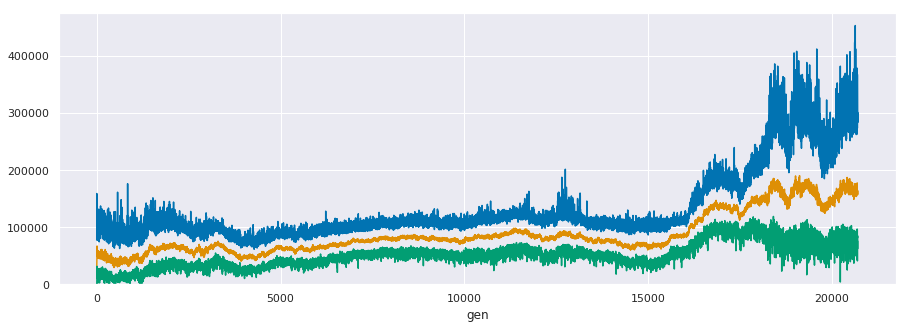

gen: 19999


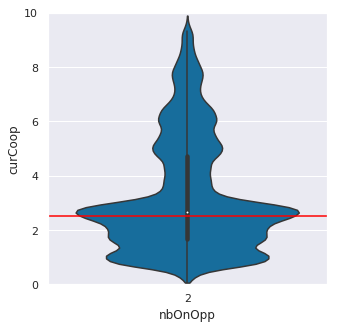

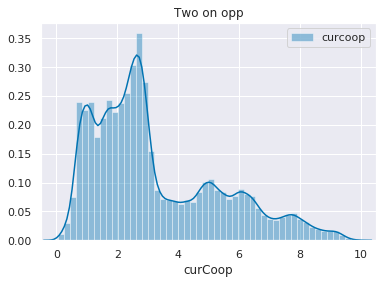

3.256261016886403


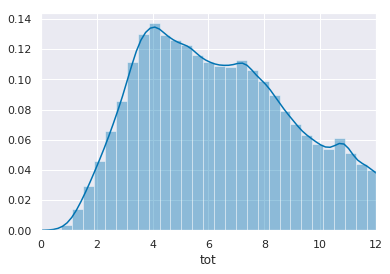

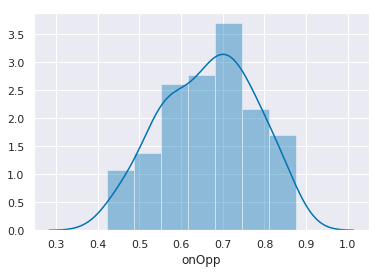

/data/logs/ab-testing-2018-08-01-1128/a_5b_8/run_2/rep00/fitnesslog.txt


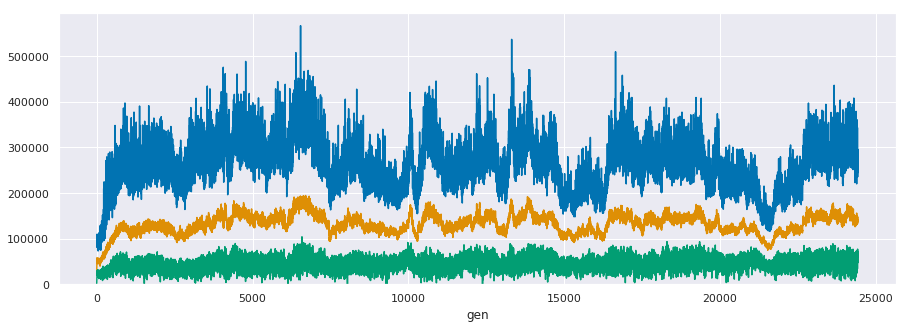

gen: 19999


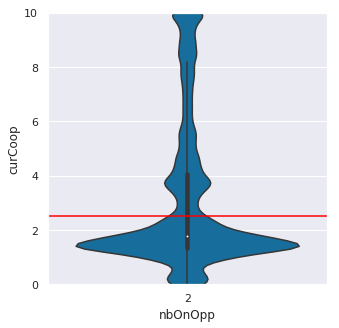

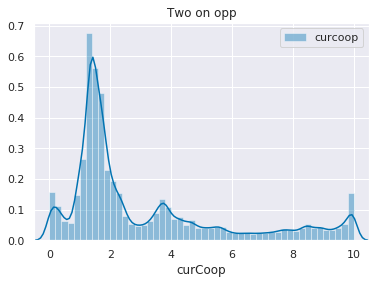

3.085805341289295


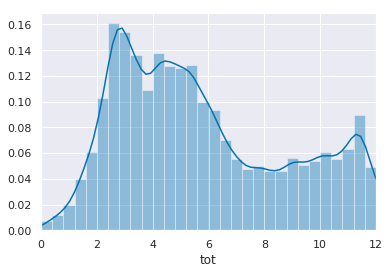

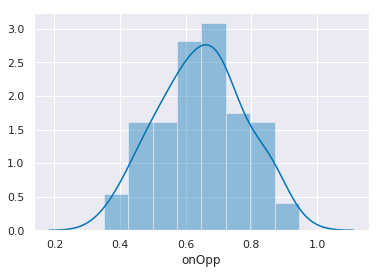

/data/logs/ab-testing-2018-08-01-1128/a_5b_8/run_3/rep00/fitnesslog.txt


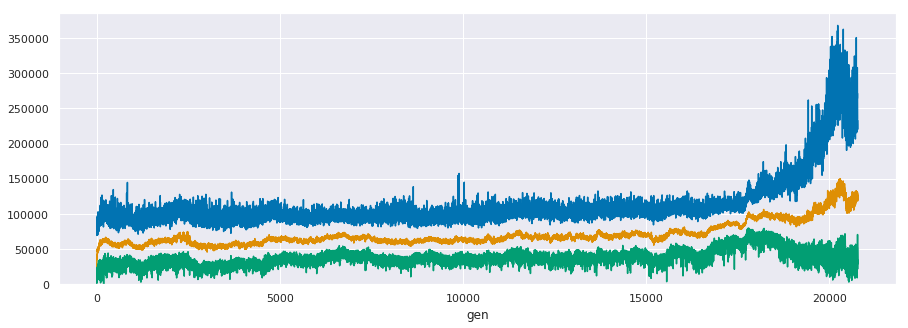

gen: 19999


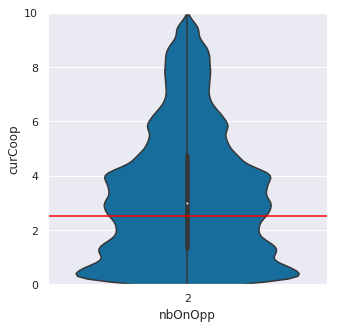

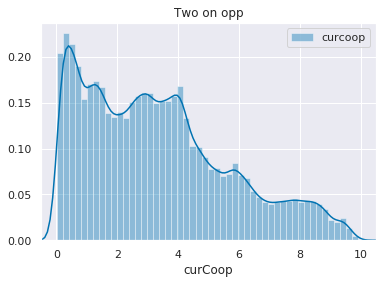

3.3242751393028827


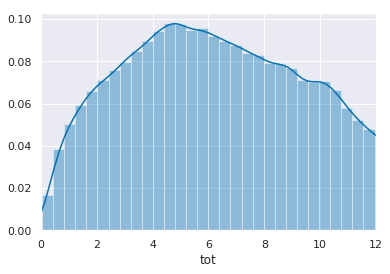

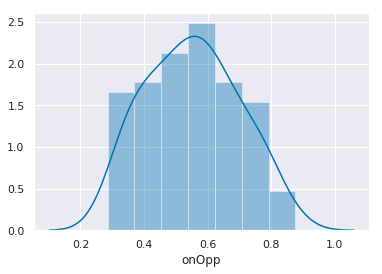

/data/logs/ab-testing-2018-08-01-1128/a_5b_8/run_4/rep00/fitnesslog.txt


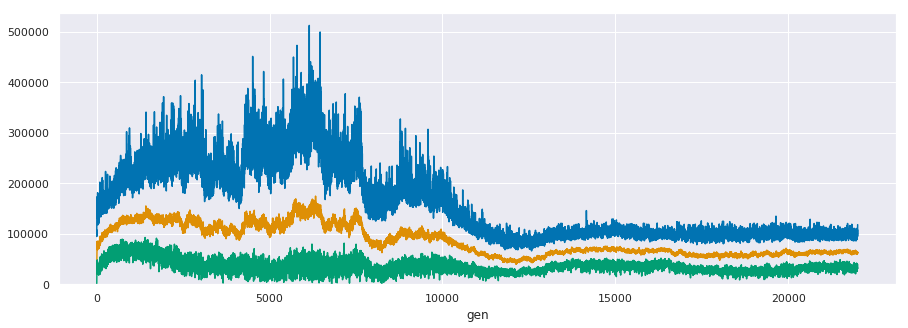

gen: 19999


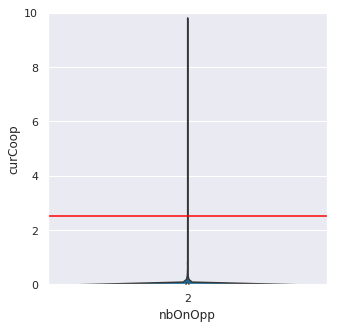

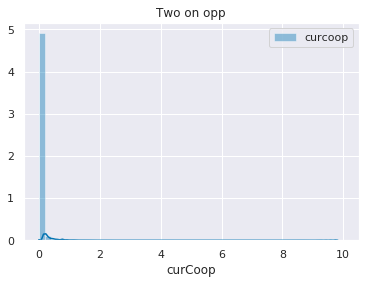

0.03970744457117691


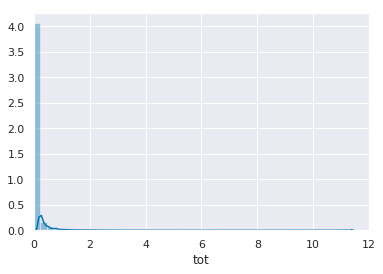

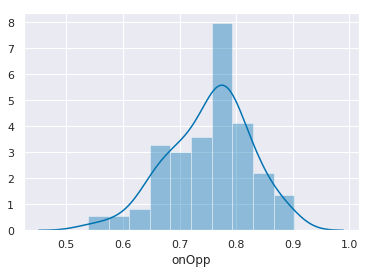

/data/logs/ab-testing-2018-08-01-1128/a_5b_8/run_5/rep00/fitnesslog.txt


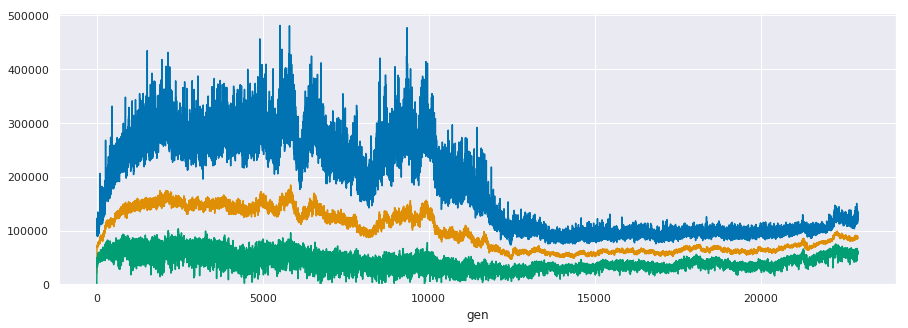

gen: 19999


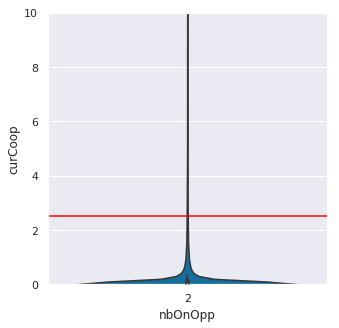

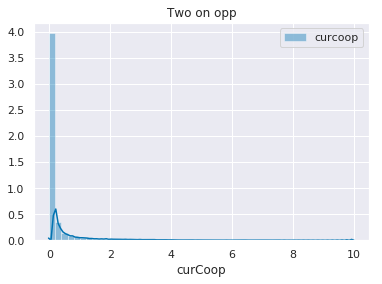

0.32448289700541855


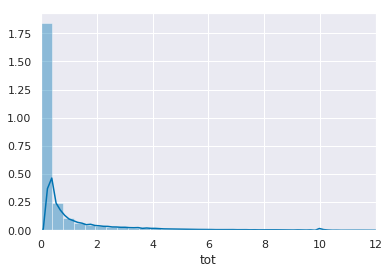

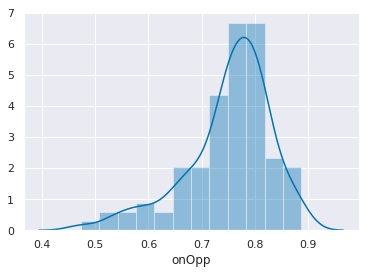

In [5]:

gens = [19999]

conds = sorted(glob(f'/data/logs/ab-testing-2018-08-01-1128/**/rep00', recursive=True))

for cond in conds:
    try:
        fitpath = Path(cond) / "fitnesslog.txt"
        fit = pd.read_csv(fitpath, delimiter="\t")
    except Exception as e:
        print('fail with', fitpath)
        try:
            fit = pd.read_csv(str(fitpath) + '.gz', delimiter="\t")
        except Exception as e:
            print(e)
            pass
        
    else:
        print(fitpath)

    fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))
    maxrep = fit['rep'].max()
    fit = fit.query(f'rep == {maxrep}')
    fit.groupby('gen')['fitness'].max().plot(ax=ax1)
    fit.groupby('gen')['fitness'].median().plot(ax=ax1)
    fit.groupby('gen')['fitness'].min().plot(ax=ax1)
    ax1.set_ylim(0, None)
    plt.show(fig)

    for gen in gens:
        logfile = join(cond, f'logall_{gen}.txt')
        i = 0
        ok = True
        to_format = '{' in logfile
        logs = []
        while ok:
            try:
                dat = read_csvx(logfile.format(i), delimiter="\t")
                dat["eval"] = i
                logs.append(dat)
            except:
                ok = False
            else:
                i += 1
                ok = to_format
        try:
            log = pd.concat(logs).query('fake == 0').copy() # Fakes are removed from data
        except Exception:
            plt.show(fig)
            print("no data, continue")
            continue
        print("gen:", gen)
        fig, ax2 = plt.subplots(1, 1, figsize=(5, 5))
        sns.violinplot(data=log.query('2 <= nbOnOpp <= 2 and onOpp == 1'), x='nbOnOpp', y='curCoop', cut=0, ax=ax2, scale='count')
        ax2.axhline(2.5, color="red")
        ax2.set_ylim(0, 10)
        plt.show(fig)

        on_opp = log.query('onOpp == 1 and nbOnOpp == 1')
        fig, ax1 = plt.subplots(1,1, sharex=True)

        ax = ax1
        on_opp = log.query('onOpp == 1 and nbOnOpp == 2').copy()
        sns.distplot(on_opp['curCoop'], label="curcoop", ax=ax)
        ax.set_xlim(-0.5, 10.5)
        #sns.distplot(on_opp['a'], label="ess")
        ax.legend()
        ax.set_title('Two on opp')
        plt.show(fig)
        print(on_opp['curCoop'].mean())
        
        fig, ax = plt.subplots()
        
        on_opp['tot'] = on_opp['meanTotal'] + on_opp['curCoop']
        
        sns.distplot(on_opp['tot'], ax=ax)
        ax.set_xlim(0, 12)
        plt.show(fig)
        
        fig, ax = plt.subplots()
        sns.distplot(log.groupby('id')['onOpp'].mean())
        plt.show()


In [ ]:
print(scipy.stats.normaltest(on_opp['curCoop']))
print(scipy.stats.normaltest(on_opp['a']))

Not normal, so wilcoxon

In [5]:
scipy.stats.wilcoxon(on_opp['curCoop'], on_opp['a']/on_opp['nbOnOpp'])

NameError: name 'on_opp' is not defined

In [6]:
on_opp['curCoop'].median(), (on_opp['a']/on_opp['nbOnOpp']).median()

NameError: name 'on_opp' is not defined

In [7]:
try: 
    sns.distplot(log.groupby('id').mean()['a'])
except:
    print("a ne varie pas")

a ne varie pas


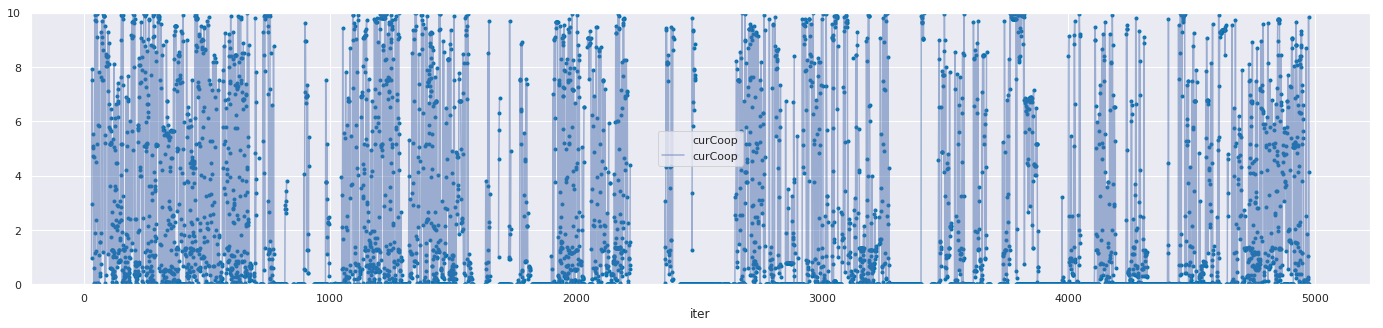

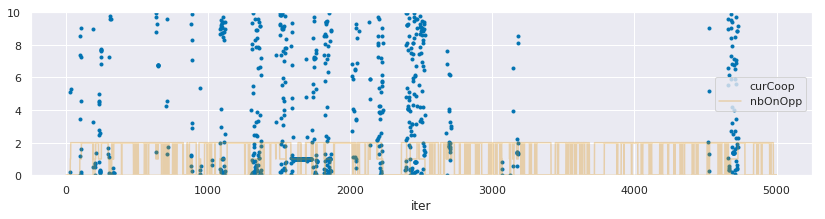

In [5]:
beg = 0
end = 5000
ind = 0
fig = plt.figure(figsize=(24,5))
ax = fig.gca()
nlog = log.query('fake == 0').copy()
nlog['curCoop'] = np.where(nlog['nbOnOpp'] == 2, nlog['curCoop'], np.nan)
nlog.query('id == {}'.format(ind)).plot(x='iter', y='curCoop', ax=ax, style='.')
nlog.query('id == {}'.format(ind)).plot(x='iter', y='curCoop', ax=ax, style='-', c='b', alpha=0.5)
#nlog.query('id == {}'.format(ind)).plot(alpha=0.3, x='iter', y='nbOnOpp', ax=ax)
ax.set_ylim(0, 10)

fig = plt.figure(figsize=(14,3))
ax = fig.gca()
nlog = log.copy()
nlog['curCoop'] = np.where(nlog['nbOnOpp'] == 1, nlog['curCoop'], np.nan)
nlog.query('id == {}'.format(ind)).plot(x='iter', y='curCoop', ax=ax, style='.')
nlog.query('id == {}'.format(ind)).plot(alpha=0.3, x='iter', y='nbOnOpp', ax=ax)
ax.set_ylim(0, 10);

In [9]:
%%script false 
c = 1
defforgive = 0
forgive = defforgive
log['step'] = np.nan
for e in log['eval'].unique():
    for j in log['id'].unique():
        for i, elem in log.query(f'id == {j} and eval == {e}').iterrows():
            if elem['onOpp'] == 1:
                if elem['nbOnOpp'] >= 2:
                    log.at[i, 'step'] = c
                    c += 1
                    forgive = defforgive
                else:
                    forgive -= 1
                    if forgive > 0 and c > 1:
                        log.at[i, 'step'] = c
                        c += 1
                        print("forgiven")
                    else:
                        c = 1
                        forgive = defforgive
            else:
                c = 1
                forgive = defforgive
        c=1
        forgive = defforgive

In [10]:
log.query('id == 2 and step >= 1')

UndefinedVariableError: name 'step' is not defined

In [ ]:
fig = plt.figure()
ax = fig.gca()
sns.distplot(log.query('step > 40 and nbOnOpp == 2')['curCoop'], ax=ax)
ax.set_xlim(0, 10)

fig = plt.figure()
ax = fig.gca()
sns.distplot(log.query('step >= 0 and nbOnOpp == 2')['curCoop'], ax=ax)
ax.set_xlim(0, 10)


In [123]:
log.groupby('step').mean().plot(y='curCoop')

KeyError: 'step'

In [140]:
log.query('curCoop > 3 and nbOnOpp == 2')

,eval,iter,id,a,onOpp,nbOnOpp,curCoop,meanOwn,meanTotal
283,0,9,13,5,1,2,4.01307,4.01307,5.03242
332,0,11,2,5,1,2,3.76133,2.39883,2.88289
362,0,12,2,5,1,2,3.19235,2.66334,3.04648
392,0,13,2,5,1,2,3.44265,2.85817,3.18960
414,0,13,24,5,1,2,4.49956,4.54894,4.58513
422,0,14,2,5,1,2,3.59677,3.00589,3.29687
452,0,15,2,5,1,2,3.71399,3.12390,3.41688
482,0,16,2,5,1,2,3.75964,3.21472,3.50742
502,0,16,22,5,1,2,3.85873,3.85873,8.28744
503,0,16,23,5,1,2,4.42872,4.44664,5.73288


/home/pecoffet/miniconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


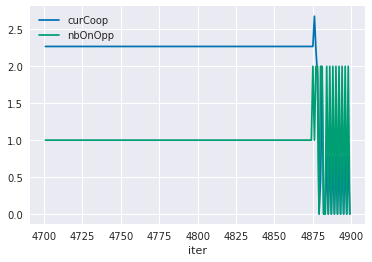

In [141]:
log.query(f'eval == 0 and 4700 < iter < 4900 and id == 3').plot(x='iter', y=['curCoop', 'nbOnOpp'])


In [142]:
def p(invest, totalInvest, a, n):
    b = 1
    return (a * totalInvest + b * (totalInvest - invest)) / n - 0.5 * invest * invest

1.3332743691034283

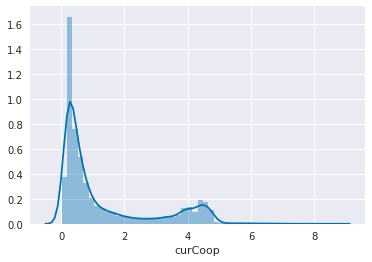

In [143]:
curcoop = log.query('nbOnOpp == 2')['curCoop']
meantot = log.query('nbOnOpp == 2')['meanTotal']
a = log.query('nbOnOpp == 2')['a']
n = log.query('nbOnOpp == 2')['nbOnOpp']
sns.distplot(curcoop)
curcoop.mean()

In [144]:
cur = p(curcoop, meantot, a, n).sum()
cur

333052.50806842686

In [145]:
opti = p(a/n, meantot - curcoop + a/n, a, n).sum()
opti

443171.05738315

In [146]:
(cur - opti) / opti

-0.24847865734949953